# Final Project

This project uses this Kaggle dataset: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/code

It includes images of brains with and without brain tumors. The scope of my work is to use a convolutional neural network (CNN) to classify whether a test image has a brain tumor or not. 

#### <font color='red'>Wally Chang wsc46</font>

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import cv2
import os
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [3]:
no_folder_path = 'C:\\Users\\Wally\\OneDrive\\INFO 3950\\Final Project\\yes-no\\no'

no_images = []

for file_name in os.listdir(no_folder_path):
    if file_name.endswith('.jpg'):
        image_path = os.path.join(no_folder_path, file_name)  # Get the full file path
        image = cv2.imread(image_path)
        no_images.append(image)

In [4]:
yes_folder_path = 'C:\\Users\\Wally\\OneDrive\\INFO 3950\\Final Project\\yes-no\\yes'

yes_images = []

for file_name in os.listdir(yes_folder_path):
    if file_name.endswith('.jpg'):
        image_path = os.path.join(yes_folder_path, file_name) 
        image = cv2.imread(image_path)
        yes_images.append(image)

## Visualization of Brain Tumor vs Normal Brain

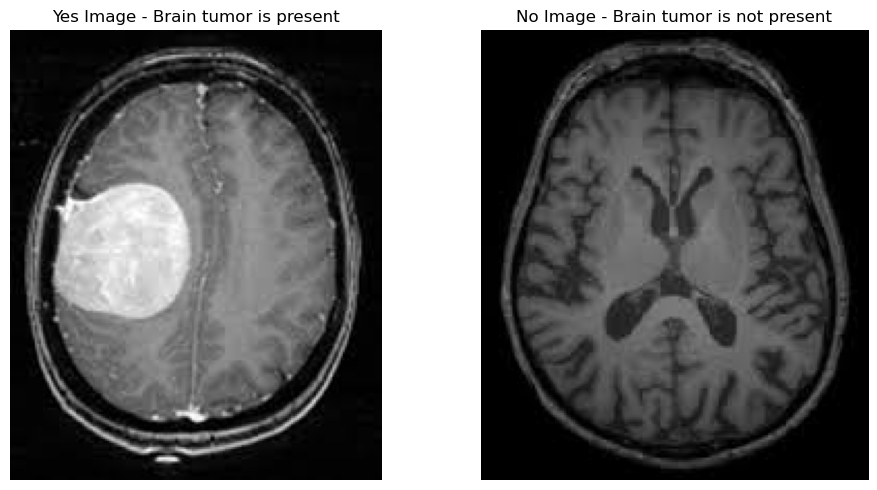

In [5]:
# Examples of MRI scans to visualize what a brain tumor looks like versus a normal brain

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(yes_images[0])
axes[0].set_title("Yes Image - Brain tumor is present")
axes[0].axis('off')

axes[1].imshow(no_images[0])
axes[1].set_title("No Image - Brain tumor is not present")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Data Loading

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize image data
])

data_dir = 'C:\\Users\\Wally\\OneDrive\\INFO 3950\\Final Project\\yes-no'

# Load the entire dataset using ImageFolder
dataset = ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Building the Model

In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(8, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(16, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(21632, 256),  # Updated input size based on the output of the previous layer
    nn.ReLU(),
    
    nn.Linear(256, 64),
    nn.ReLU(),
    
    nn.Linear(64, 2)
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()

model.to(device)
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training the Model

In [8]:
epochs = 25
scores = []

for t in range(epochs):
    train_loss = []
    train_accuracy = []
    print(f'Epoch {t+1}: ', end='')

    #model.train() 
    for batch,(x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_accuracy.append((pred.argmax(1) == y).sum().item() / len(pred))        

    #model.eval()  #turns off dropout
    
    test_loss = []
    test_accuracy = []
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        test_loss.append(loss.item())
        test_accuracy.append((pred.argmax(1) == y).sum().item() / len(pred))
    
    print(f'epoch: {t}, train loss: {np.mean(train_loss):.5f}, test loss: {np.mean(test_loss):.5f}, ' +\
          f'train_score: {np.mean(train_accuracy):.1%}, test_score: {np.mean(test_accuracy):.1%}')
    scores.append((np.mean(train_loss),np.mean(test_loss),np.mean(train_accuracy),np.mean(test_accuracy)))

Epoch 1: epoch: 0, train loss: 0.66698, test loss: 0.61978, train_score: 60.5%, test_score: 60.8%
Epoch 2: epoch: 1, train loss: 0.58775, test loss: 0.54562, train_score: 64.1%, test_score: 74.3%
Epoch 3: epoch: 2, train loss: 0.53081, test loss: 0.50865, train_score: 79.7%, test_score: 76.4%
Epoch 4: epoch: 3, train loss: 0.46400, test loss: 0.54509, train_score: 75.6%, test_score: 75.9%
Epoch 5: epoch: 4, train loss: 0.38871, test loss: 0.60268, train_score: 86.5%, test_score: 77.5%
Epoch 6: epoch: 5, train loss: 0.42892, test loss: 0.51523, train_score: 83.7%, test_score: 74.8%
Epoch 7: epoch: 6, train loss: 0.29285, test loss: 0.49827, train_score: 90.6%, test_score: 79.0%
Epoch 8: epoch: 7, train loss: 0.25603, test loss: 0.48118, train_score: 92.9%, test_score: 77.5%
Epoch 9: epoch: 8, train loss: 0.17740, test loss: 0.65033, train_score: 93.3%, test_score: 85.9%
Epoch 10: epoch: 9, train loss: 0.14278, test loss: 0.61793, train_score: 94.1%, test_score: 81.7%
Epoch 11: epoch: 10

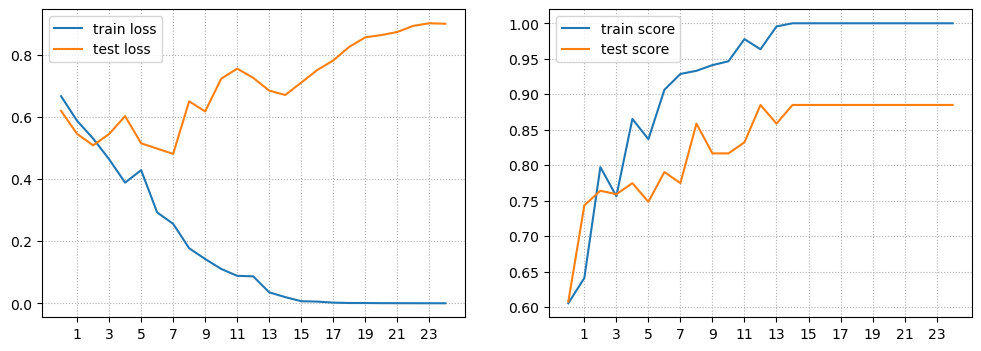

In [9]:
train_losses = [score[0] for score in scores]
test_losses = [score[1] for score in scores]
train_scores = [score[2] for score in scores]
test_scores = [score[3] for score in scores]
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(train_losses, '-', label='train loss')
plt.plot(test_losses, '-', label='test loss')
plt.xticks(range(1,25,2))
plt.legend()
plt.grid(ls=':');

plt.subplot(122)
plt.plot(train_scores, '-', label='train score')
plt.plot(test_scores, '-', label='test score')
plt.xticks(range(1,25,2))
plt.legend()
plt.grid(ls=':');

In the figures above, it can be seen that test loss is increasing as epochs progress. It is almost certainly overfitting, given the train score is 100%, and the size of the test set is relatively small compared to other data sets.
***************************************

## Visualizing the Predictions That Were Wrong

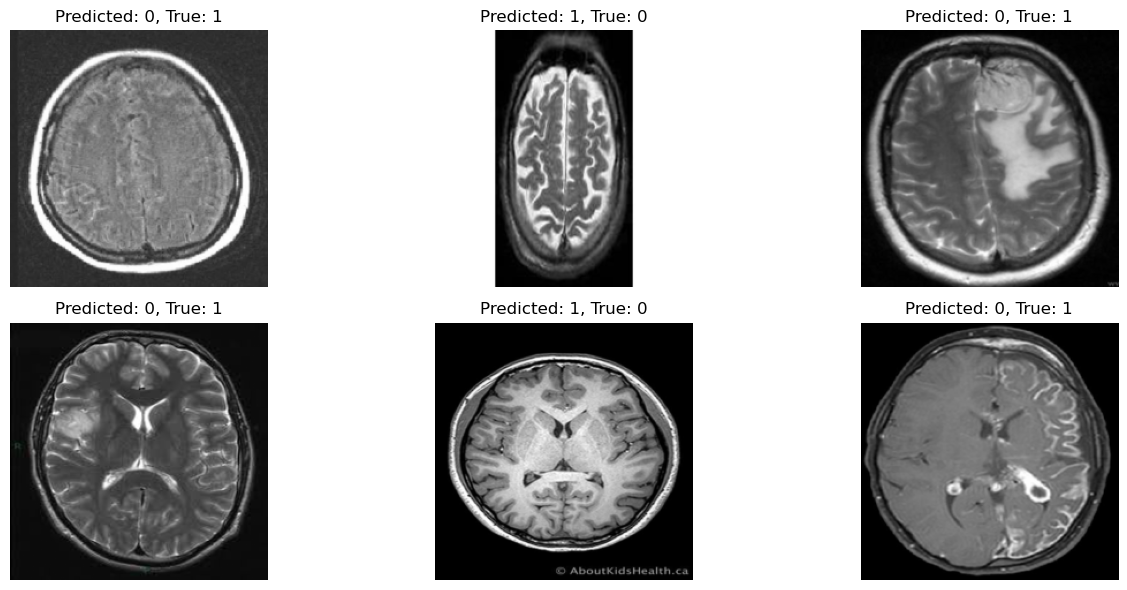

In [10]:
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

# Iterate over the test dataset
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    # Make predictions
    outputs = model(images)
    predicted_labels = torch.argmax(outputs, dim=1)
    
    # Find misclassified images
    misclassified_mask = predicted_labels != labels
    misclassified_images.extend(images[misclassified_mask])
    misclassified_labels.extend(labels[misclassified_mask])
    misclassified_predictions.extend(predicted_labels[misclassified_mask])

# Display misclassified images
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

for i in range(len(misclassified_images)):
    image = misclassified_images[i].cpu().numpy().transpose(1, 2, 0)  # Convert tensor to NumPy array
    image = (image * 0.5) + 0.5  # Unnormalize image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {misclassified_predictions[i]}, True: {misclassified_labels[i]}")

plt.tight_layout()
plt.show()